### 1. Read data

In [1]:
#packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

#sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import tree
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics 
from sklearn.model_selection import GridSearchCV

import IPython

In [2]:
#load csv
df = pd.read_csv('covid_econ_control.csv')

In [3]:
#data shape
display(df.shape)

(7852, 21)

In [4]:
#data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7852 entries, 0 to 7851
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               7852 non-null   int64  
 1   state_name               7852 non-null   object 
 2   date                     7852 non-null   object 
 3   employees                7852 non-null   float64
 4   change_in_emp            7852 non-null   float64
 5   Sector                   7852 non-null   object 
 6   Mob_res                  7852 non-null   int64  
 7   Mob_ret_rec              7852 non-null   int64  
 8   Mob_res_SA               7852 non-null   float64
 9   Mob_ret_SA               7852 non-null   float64
 10  delta_Mob_res_SA         7248 non-null   float64
 11  delta_Mob_ret_SA         7248 non-null   float64
 12  stringency_index         7852 non-null   float64
 13  delta_stringency_index   7852 non-null   float64
 14  tot_cases               

### 2. OLS

In [5]:
#split test and train
test = df[df['date']=="2021-02-28"]
train = df[df['date']!="2021-02-28"]

#further split train into Q2 or not
panic = train[(train['date']=="2020-04-30") | (train['date']=="2020-05-31") | (train['date']=="2020-06-30" )]
non_panic = train[(train['date']!="2020-04-30") & (train['date']!="2020-05-31") & (train['date']!="2020-06-30" )]

#adjust leisure Q2 for residential
panic['Mob_res_SA_leisig'] = panic['Mob_res_SA']

panic['Mob_res_SA_leisig'][panic['Sector'] == "Leisure and Hospitality"] = (-0.6695/(1+np.exp(-0.6283*(panic['Mob_res_SA'][panic['Sector'] == "Leisure and Hospitality"])+7.7792)))+0.1894

test['Mob_res_SA_leisig'] = test['Mob_res_SA']

test['Mob_res_SA_leisig'][test['Sector'] == "Leisure and Hospitality"] = (-0.6695/(1+np.exp(-0.6283*(test['Mob_res_SA'][test['Sector'] == "Leisure and Hospitality"])+7.7792)))+0.1894

#adjust leisure Q2 for retail
panic['Mob_ret_SA_leisig'] = panic['Mob_ret_SA']

panic['Mob_ret_SA_leisig'][panic['Sector'] == "Leisure and Hospitality"] = (0.5696/(1+np.exp(0.1862*(test['Mob_res_SA'][test['Sector'] == "Leisure and Hospitality"])-3.785)))-0.3932

test['Mob_ret_SA_leisig'] = test['Mob_ret_SA']

test['Mob_ret_SA_leisig'][test['Sector'] == "Leisure and Hospitality"] = (0.5696/(1+np.exp(0.1862*(test['Mob_res_SA'][test['Sector'] == "Leisure and Hospitality"])-3.785)))-0.3932

<ipython-input-5-d878def12853>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  panic['Mob_res_SA_leisig'] = panic['Mob_res_SA']
<ipython-input-5-d878def12853>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  panic['Mob_res_SA_leisig'][panic['Sector'] == "Leisure and Hospitality"] = (-0.6695/(1+np.exp(-0.6283*(panic['Mob_res_SA'][panic['Sector'] == "Leisure and Hospitality"])+7.7792)))+0.1894
/Users/nicolasmin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [6]:
#run multiple regression on residential - Q2 2020
linear_model_panic = sm.ols(formula = "change_in_emp ~ Mob_res_SA_leisig*(C(Sector)-1) + stringency_index*(C(Sector)-1) + blue_state + red_state + tot_death", 
             data=panic, missing='drop').fit()
display(linear_model_panic.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          change_in_emp   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     99.83
Date:                Thu, 06 May 2021   Prob (F-statistic):               0.00
Time:                        17:37:17   Log-Likelihood:                 2510.8
No. Observations:                1812   AIC:                            -4944.
Df Residuals:                    1773   BIC:                            -4729.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                             0.1286      0.023      5.605      0.000       0.084       0.174
C(Sector)[T.Education and Health Services]                            0.0099      0.032      0.314      0.754      -0.052       0.072
C(Sector)[T.Financial Activities]                                    -0.0598      0.032     -1.890      0.059      -0.122       0.002
C(Sector)[T.Government]                                              -0.0674      0.032     -2.131      0.033      -0.129      -0.005
C(Sector)[T.Information]                                             -0.0220      0.032     -0.693      0.488      -0.084       0.040
C(Sector)[T.Leisure and Hospitality]                                 -0.0602      0.035     -1.727      0.084      -0.129       0.008
C(Sector)[T.Manufacturing]                                            0.0134      0.032      0.425      0.671      -0.049       0.075
C(Sector)[T.Mining and Logging]                                      -0.0897      0.032     -2.814      0.005      -0.152      -0.027
C(Sector)[T.Professional and Business Services]                      -0.0135      0.032     -0.426      0.670      -0.076       0.049
C(Sector)[T.Retail Trade]                                             0.0833      0.032      2.633      0.009       0.021       0.145
C(Sector)[T.Transportation and Utilities]                            -0.0122      0.032     -0.384      0.701      -0.074       0.050
C(Sector)[T.Wholesale Trade]                                         -0.0404      0.032     -1.277      0.202      -0.102       0.022
Mob_res_SA_leisig                                                    -0.0175      0.001    -12.772      0.000      -0.020      -0.015
Mob_res_SA_leisig:C(Sector)[T.Education and Health Services]          0.0057      0.002      3.037      0.002       0.002       0.009
Mob_res_SA_leisig:C(Sector)[T.Financial Activities]                   0.0124      0.002      6.604      0.000       0.009       0.016
Mob_res_SA_leisig:C(Sector)[T.Government]                             0.0124      0.002      6.597      0.000       0.009       0.016
Mob_res_SA_leisig:C(Sector)[T.Information]                            0.0097      0.002      5.140      0.000       0.006       0.013
Mob_res_SA_leisig:C(Sector)[T.Leisure and Hospitality]                1.0271      0.026     40.151      0.000       0.977       1.077
Mob_res_SA_leisig:C(Sector)[T.Manufacturing]                          0.0042      0.002      2.263      0.024       0.001       0.008
Mob_res_SA_leisig:C(Sector)[T.Mining and Logging]                     0.0102      0.002      5.252      0.000       0.006       0.014
M

In [7]:
#run multiple regression on residential - non-Q2 2020
linear_model_nonpanic = sm.ols(formula = "change_in_emp ~ Mob_res_SA*(C(Sector)-1) + stringency_index*(C(Sector)-1) + blue_state + red_state + tot_death", 
             data=non_panic, missing='drop').fit()
display(linear_model_nonpanic.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          change_in_emp   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     24.03
Date:                Thu, 06 May 2021   Prob (F-statistic):          5.27e-153
Time:                        17:37:17   Log-Likelihood:                 13808.
No. Observations:                5436   AIC:                        -2.754e+04
Df Residuals:                    5397   BIC:                        -2.728e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
====================================================================================================================================
                                                                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                            0.0047      0.002      1.992      0.046    7.45e-05       0.009
C(Sector)[T.Education and Health Services]                        1.184e-05      0.003      0.004      0.997      -0.006       0.006
C(Sector)[T.Financial Activities]                                   -0.0007      0.003     -0.211      0.833      -0.007       0.006
C(Sector)[T.Government]                                             -0.0009      0.003     -0.292      0.770      -0.007       0.005
C(Sector)[T.Information]                                            -0.0040      0.003     -1.231      0.218      -0.010       0.002
C(Sector)[T.Leisure and Hospitality]                                 0.0168      0.003      5.225      0.000       0.011       0.023
C(Sector)[T.Manufacturing]                                          -0.0010      0.003     -0.301      0.763      -0.007       0.005
C(Sector)[T.Mining and Logging]                                     -0.0076      0.003     -2.301      0.021      -0.014      -0.001
C(Sector)[T.Professional and Business Services]                      0.0010      0.003      0.315      0.753      -0.005       0.007
C(Sector)[T.Retail Trade]                                            0.0004      0.003      0.127      0.899      -0.006       0.007
C(Sector)[T.Transportation and Utilities]                           -0.0024      0.003     -0.738      0.460      -0.009       0.004
C(Sector)[T.Wholesale Trade]                                        -0.0022      0.003     -0.682      0.495      -0.009       0.004
Mob_res_SA                                                          -0.0007      0.000     -2.863      0.004      -0.001      -0.000
Mob_res_SA:C(Sector)[T.Education and Health Services]               -0.0001      0.000     -0.366      0.714      -0.001       0.001
Mob_res_SA:C(Sector)[T.Financial Activities]                         0.0004      0.000      1.182      0.237      -0.000       0.001
Mob_res_SA:C(Sector)[T.Government]                                   0.0001      0.000      0.346      0.730      -0.001       0.001
Mob_res_SA:C(Sector)[T.Information]                                 -0.0002      0.000     -0.510      0.610      -0.001       0.000
Mob_res_SA:C(Sector)[T.Leisure and Hospitality]                     -0.0050      0.000    -14.512      0.000      -0.006      -0.004
Mob_res_SA:C(Sector)[T.Manufacturing]                                0.0002      0.000      0.650      0.516      -0.000       0.001
Mob_res_SA:C(Sector)[T.Mining and Logging]                           0.0008      0.000      2.282      0.023       0.000       0.002
Mob_res_SA:C(Sector)[T.P

In [8]:
# run multiple regression on retail - Q2 2020
linear_model_panic = sm.ols(formula = "change_in_emp ~ Mob_ret_SA_leisig*(C(Sector)-1) + stringency_index*(C(Sector)-1) + blue_state + red_state + tot_death", 
             data=panic, missing='drop').fit()
display(linear_model_panic.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          change_in_emp   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     33.65
Date:                Thu, 06 May 2021   Prob (F-statistic):          4.58e-165
Time:                        17:37:17   Log-Likelihood:                 2587.8
No. Observations:                1659   AIC:                            -5104.
Df Residuals:                    1623   BIC:                            -4909.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                             0.0378      0.022      1.759      0.079      -0.004       0.080
C(Sector)[T.Education and Health Services]                            0.0333      0.030      1.122      0.262      -0.025       0.092
C(Sector)[T.Financial Activities]                                    -0.0105      0.030     -0.352      0.725      -0.069       0.048
C(Sector)[T.Government]                                              -0.0256      0.030     -0.860      0.390      -0.084       0.033
C(Sector)[T.Information]                                              0.0174      0.030      0.583      0.560      -0.041       0.076
C(Sector)[T.Leisure and Hospitality]                              -4.712e-13   4.27e-13     -1.103      0.270   -1.31e-12    3.67e-13
C(Sector)[T.Manufacturing]                                            0.0321      0.030      1.080      0.280      -0.026       0.090
C(Sector)[T.Mining and Logging]                                      -0.0449      0.030     -1.493      0.136      -0.104       0.014
C(Sector)[T.Professional and Business Services]                       0.0163      0.030      0.548      0.584      -0.042       0.075
C(Sector)[T.Retail Trade]                                             0.0684      0.030      2.303      0.021       0.010       0.127
C(Sector)[T.Transportation and Utilities]                             0.0063      0.030      0.211      0.833      -0.052       0.065
C(Sector)[T.Wholesale Trade]                                         -0.0055      0.030     -0.187      0.852      -0.064       0.053
Mob_ret_SA_leisig                                                     0.0040      0.000     10.703      0.000       0.003       0.005
Mob_ret_SA_leisig:C(Sector)[T.Education and Health Services]         -0.0013      0.001     -2.573      0.010      -0.002      -0.000
Mob_ret_SA_leisig:C(Sector)[T.Financial Activities]                  -0.0027      0.001     -5.437      0.000      -0.004      -0.002
Mob_ret_SA_leisig:C(Sector)[T.Government]                            -0.0025      0.001     -4.905      0.000      -0.003      -0.001
Mob_ret_SA_leisig:C(Sector)[T.Information]                           -0.0022      0.001     -4.334      0.000      -0.003      -0.001
Mob_ret_SA_leisig:C(Sector)[T.Leisure and Hospitality]             -9.14e-17   4.21e-16     -0.217      0.828   -9.17e-16    7.34e-16
Mob_ret_SA_leisig:C(Sector)[T.Manufacturing]                         -0.0010      0.001     -2.013      0.044      -0.002   -2.59e-05
Mob_ret_SA_leisig:C(Sector)[T.Mining and Logging]                    -0.0024      0.001     -4.486      0.000      -0.003      -0.001
M

In [9]:
# run multiple regression on retail - non-Q2 2020
linear_model_nonpanic = sm.ols(formula = "change_in_emp ~ Mob_ret_SA*(C(Sector)-1) + stringency_index*(C(Sector)-1) + blue_state + red_state + tot_death", 
             data=non_panic, missing='drop').fit()
display(linear_model_nonpanic.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          change_in_emp   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     12.36
Date:                Thu, 06 May 2021   Prob (F-statistic):           2.87e-72
Time:                        17:37:17   Log-Likelihood:                 13610.
No. Observations:                5436   AIC:                        -2.714e+04
Df Residuals:                    5397   BIC:                        -2.688e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
====================================================================================================================================
                                                                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                           -0.0003      0.003     -0.119      0.905      -0.006       0.005
C(Sector)[T.Education and Health Services]                           0.0012      0.004      0.328      0.743      -0.006       0.008
C(Sector)[T.Financial Activities]                                    0.0021      0.004      0.559      0.576      -0.005       0.009
C(Sector)[T.Government]                                              0.0018      0.004      0.484      0.628      -0.005       0.009
C(Sector)[T.Information]                                            -0.0010      0.004     -0.280      0.780      -0.008       0.006
C(Sector)[T.Leisure and Hospitality]                                 0.0019      0.004      0.503      0.615      -0.005       0.009
C(Sector)[T.Manufacturing]                                           0.0012      0.004      0.313      0.755      -0.006       0.008
C(Sector)[T.Mining and Logging]                                      0.0013      0.004      0.341      0.733      -0.006       0.009
C(Sector)[T.Professional and Business Services]                      0.0021      0.004      0.562      0.574      -0.005       0.009
C(Sector)[T.Retail Trade]                                         7.104e-05      0.004      0.019      0.985      -0.007       0.007
C(Sector)[T.Transportation and Utilities]                           -0.0008      0.004     -0.217      0.828      -0.008       0.006
C(Sector)[T.Wholesale Trade]                                         0.0011      0.004      0.309      0.758      -0.006       0.008
Mob_ret_SA                                                           0.0003   8.54e-05      3.299      0.001       0.000       0.000
Mob_ret_SA:C(Sector)[T.Education and Health Services]            -9.751e-05      0.000     -0.848      0.396      -0.000       0.000
Mob_ret_SA:C(Sector)[T.Financial Activities]                        -0.0002      0.000     -1.539      0.124      -0.000    4.84e-05
Mob_ret_SA:C(Sector)[T.Government]                                  -0.0002      0.000     -1.664      0.096      -0.000    3.41e-05
Mob_ret_SA:C(Sector)[T.Information]                                 -0.0002      0.000     -1.899      0.058      -0.000    7.07e-06
Mob_ret_SA:C(Sector)[T.Leisure and Hospitality]                      0.0008      0.000      6.686      0.000       0.001       0.001
Mob_ret_SA:C(Sector)[T.Manufacturing]                               -0.0001      0.000     -1.246      0.213      -0.000    8.21e-05
Mob_ret_SA:C(Sector)[T.Mining and Logging]                          -0.0006      0.000     -4.773      0.000      -0.001      -0.000
Mob_ret_SA:C(Sector)[T.P

RMSE:  0.07102981248298613


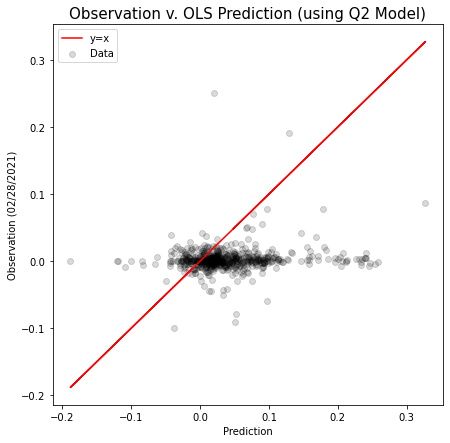

In [10]:
#prediction
panic_pred = linear_model_panic.predict(test)

#RMSE
print("RMSE: ",np.sqrt(metrics.mean_squared_error(test['change_in_emp'], panic_pred)))

#plot
# set size
plt.figure(figsize=(7,7))

# label
plt.xlabel('Prediction')
plt.ylabel('Observation (02/28/2021)')

# title
plt.title('Observation v. OLS Prediction (using Q2 Model)', fontsize=15)

# scatterplot
plt.scatter(panic_pred,test['change_in_emp'], color= 'black', alpha=0.15, label="Data")

# y=x
plt.plot(panic_pred, panic_pred, color = 'red', label="y=x")


# labels on regression line
#plt.text(0.1,0.2,'y = x', color = 'red')
plt.legend(loc='upper left')
plt.show()

RMSE:  0.019382446618401935


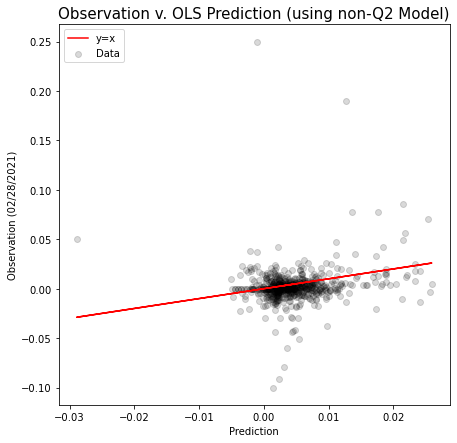

In [12]:
#prediction
nonpanic_pred = linear_model_nonpanic.predict(test)

#RMSE
print("RMSE: ",np.sqrt(metrics.mean_squared_error(test['change_in_emp'], nonpanic_pred)))

#plot
# set size
plt.figure(figsize=(7,7))

# label
plt.xlabel('Prediction')
plt.ylabel('Observation (02/28/2021)')

# title
plt.title('Observation v. OLS Prediction (using non-Q2 Model)', fontsize=15)

# scatterplot
plt.scatter(nonpanic_pred,test['change_in_emp'], color= 'black', alpha=0.15, label="Data")

# y=x
plt.plot(nonpanic_pred, nonpanic_pred, color = 'red', label="y=x")


# labels on regression line
#plt.text(0.02,0.04,'y = x', color = 'red')
plt.legend(loc='upper left')
plt.show()

### 3. Random Forest

In [62]:
#leave only the variables used in OLS
df_rf = df.iloc[:,[2,4,5,8,12,15,18,19]]

#change categorical columns to binary columns
#and combine
sector_df = pd.get_dummies(df_rf['Sector'])
df_rf = df_rf.drop(columns = 'Sector')
df_rf = pd.concat([df_rf, sector_df], axis = 1)

#split test and train
test_rf = df_rf[df_rf['date']=="2021-02-28"]
train_rf = df_rf[df_rf['date']!="2021-02-28"]

#further split train into Q2 or not
panic_rf = train_rf[(train_rf['date']=="2020-04-30") | (train_rf['date']=="2020-05-31") | (train_rf['date']=="2020-06-30" )]
nonpanic_rf = train_rf[(train_rf['date']!="2020-04-30") & (train_rf['date']!="2020-05-31") & (train_rf['date']!="2020-06-30" )]

#drop dates now
panic_rf = panic_rf.drop(columns = 'date')
nonpanic_rf = nonpanic_rf.drop(columns = 'date')
test_rf = test_rf.drop(columns = 'date')

In [63]:
#split features and emp
panic_rf_emp = panic_rf['change_in_emp']
nonpanic_rf_emp = nonpanic_rf['change_in_emp']
test_rf_emp = test_rf['change_in_emp']

panic_rf_features = panic_rf.drop(columns = 'change_in_emp')
nonpanic_rf_features = nonpanic_rf.drop(columns = 'change_in_emp')
test_rf_features = test_rf.drop(columns = 'change_in_emp')

In [64]:
import warnings
warnings.filterwarnings('ignore')

#Finding hyperparameters
clf_panic = RandomForestRegressor()

# Choose some parameter combinations to try
parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'],
              'max_depth':  [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

# Run the grid search
grid_obj_panic = GridSearchCV(clf_panic, parameters)
grid_obj_panic = grid_obj_panic.fit(panic_rf_features, panic_rf_emp)

# Set the clf to the best combination of parameters
clf_panic = grid_obj_panic.best_estimator_

# Fit the best algorithm to the data. 
clf_panic.fit(panic_rf_features, panic_rf_emp)

#print best parameters
print(grid_obj_panic.best_params_)

{'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 9}


RMSE:  0.053805805811169276


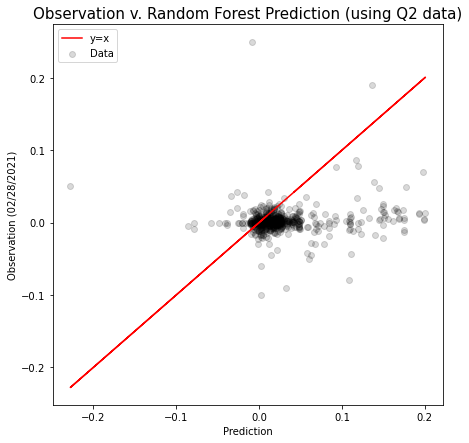

In [65]:
#predict using the model
pred_rf_panic = clf_panic.predict(test_rf_features)

#RMSE
print("RMSE: ",np.sqrt(metrics.mean_squared_error(test_rf_emp, pred_rf_panic)))

#plot
# set size
plt.figure(figsize=(7,7))

# label
plt.xlabel('Prediction')
plt.ylabel('Observation (02/28/2021)')

# title
plt.title('Observation v. Random Forest Prediction (using Q2 data)', fontsize=15)

# scatterplot
plt.scatter( pred_rf_panic,test_rf_emp, color= 'black', alpha=0.15, label="Data")

# y=x
plt.plot( pred_rf_panic,  pred_rf_panic, color = 'red', label="y=x")


# labels on regression line
#plt.text(0.1,0.08,'y = x', color = 'red')
plt.legend(loc='upper left')
plt.show()

In [66]:
import warnings
warnings.filterwarnings('ignore')

#Finding hyperparameters
clf_nonpanic = RandomForestRegressor()

# Choose some parameter combinations to try
parameters = {'n_estimators': [4, 6, 9], 
              'max_features': ['log2', 'sqrt','auto'],
              'max_depth':  [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1,5,8]
             }

# Run the grid search
grid_obj_nonpanic = GridSearchCV(clf_nonpanic, parameters)
grid_obj_nonpanic = grid_obj_nonpanic.fit(nonpanic_rf_features, nonpanic_rf_emp)

# Set the clf to the best combination of parameters
clf_nonpanic = grid_obj_nonpanic.best_estimator_

# Fit the best algorithm to the data. 
clf_nonpanic.fit(nonpanic_rf_features, nonpanic_rf_emp)

#print best parameters
print(grid_obj_nonpanic.best_params_)

{'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 3, 'n_estimators': 9}


RMSE:  0.019338241535199557


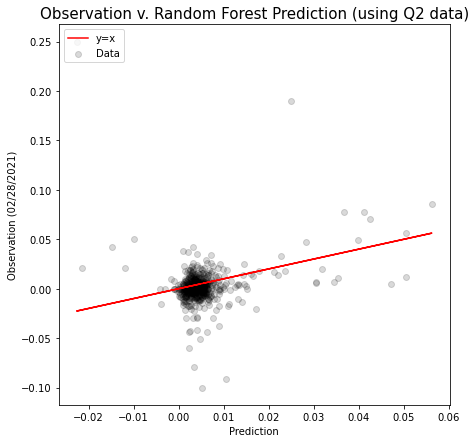

In [67]:
#predict using the model
pred_rf_nonpanic = clf_nonpanic.predict(test_rf_features)

#RMSE
print("RMSE: ",np.sqrt(metrics.mean_squared_error(test_rf_emp, pred_rf_nonpanic)))

#plot
# set size
plt.figure(figsize=(7,7))

# label
plt.xlabel('Prediction')
plt.ylabel('Observation (02/28/2021)')

# title
plt.title('Observation v. Random Forest Prediction (using non-Q2 data)', fontsize=15)

# scatterplot
plt.scatter(pred_rf_nonpanic,test_rf_emp, color= 'black', alpha=0.15, label="Data")

# y=x
plt.plot(pred_rf_nonpanic, pred_rf_nonpanic, color = 'red', label="y=x")


# labels on regression line
#plt.text(0.06,0.04,'y = x', color = 'red')
plt.legend(loc='upper left')
plt.show()

### GREAT!! 
### Random Forest isn't rendering a particularly better RMSE!
### * PANIC: OLS = 0.0710 /RF = 0.0538
### * NON-PANIC: OLS = 0.0194 /RF = 0.0193

### 4. Feature importance

,Feature_names,Importances
0,Mob_res_SA,0.464061
10,Leisure and Hospitality,0.185417
1,stringency_index,0.118718
2,tot_death,0.114219
3,blue_state,0.020338
8,Government,0.015615
4,red_state,0.014743
7,Financial Activities,0.013036
5,Construction,0.010924
12,Mining and Logging,0.010780


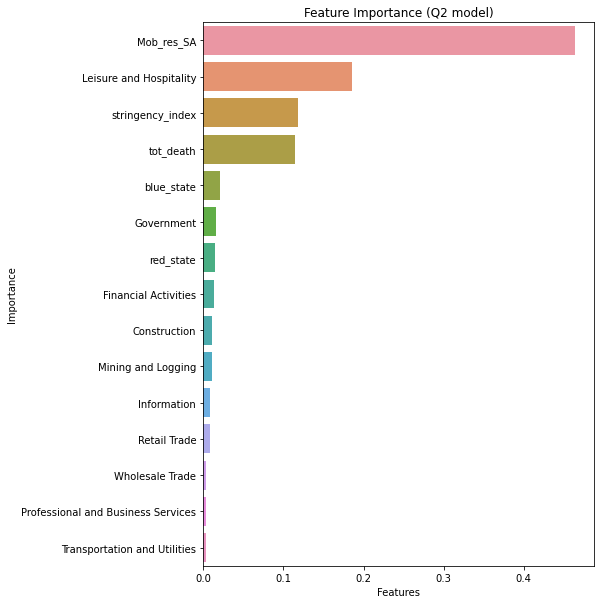

In [68]:
#create df of feature importance
feature_imp_df = pd.DataFrame({'Feature_names': panic_rf_features.columns, 'Importances': clf_panic.feature_importances_}) 
feature_imp_df = feature_imp_df.sort_values(by = 'Importances', ascending = False)
feature_imp_df = feature_imp_df.astype({'Feature_names': str})
feature_imp_df = feature_imp_df.head(15)
display(feature_imp_df)
# set size
plt.subplots(figsize=(7,10))

#plot feature importance (bar graph)
import seaborn as sns

sns.barplot(y=feature_imp_df['Feature_names'],x=feature_imp_df['Importances'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance (Q2 model)')

plt.show()

,Feature_names,Importances
0,Mob_res_SA,0.342715
2,tot_death,0.227498
10,Leisure and Hospitality,0.178862
1,stringency_index,0.157223
3,blue_state,0.024465
4,red_state,0.022312
12,Mining and Logging,0.016048
15,Transportation and Utilities,0.007934
14,Retail Trade,0.005894
9,Information,0.003960


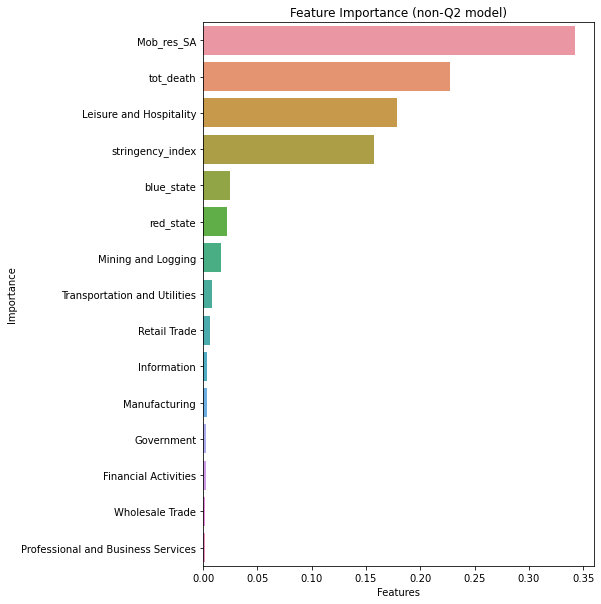

In [69]:
#create df of feature importance
feature_imp_df = pd.DataFrame({'Feature_names': nonpanic_rf_features.columns, 'Importances': clf_nonpanic.feature_importances_}) 
feature_imp_df = feature_imp_df.sort_values(by = 'Importances', ascending = False)
feature_imp_df = feature_imp_df.astype({'Feature_names': str})
feature_imp_df = feature_imp_df.head(15)
display(feature_imp_df)
# set size
plt.subplots(figsize=(7,10))

#plot feature importance (bar graph)
sns.barplot(y=feature_imp_df['Feature_names'],x=feature_imp_df['Importances'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance (non-Q2 model)')

plt.show()

### GREAT!! 
### During the panic, mobility and leisure dominates the importance! (appx 70%)

### 5. Tree diagram for PANIC - not needed

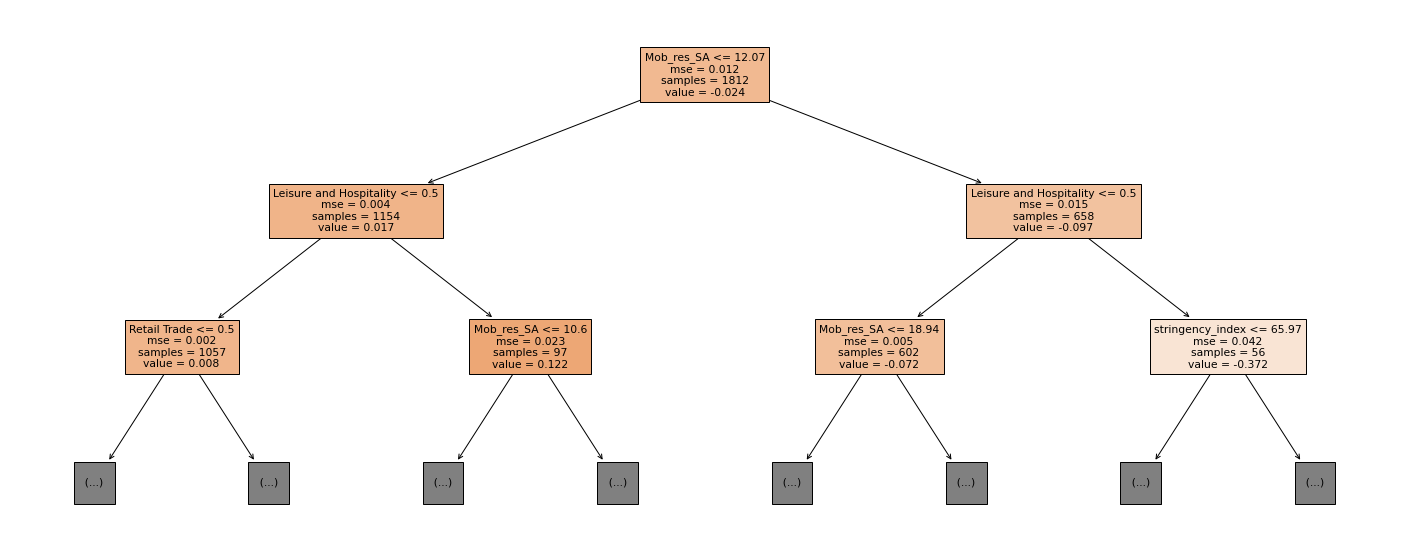

In [70]:
#Tree Diagram (one tree)

#model fit
one_tree = tree.DecisionTreeRegressor()   
one_tree.fit(panic_rf_features, panic_rf_emp)
    
#plot tree
fig = plt.figure(figsize=(25,10))
_ = tree.plot_tree(one_tree, max_depth=2,
                   feature_names=panic_rf_features.columns,
                   filled=True) 

### 6. Fitting of non-linear sector data

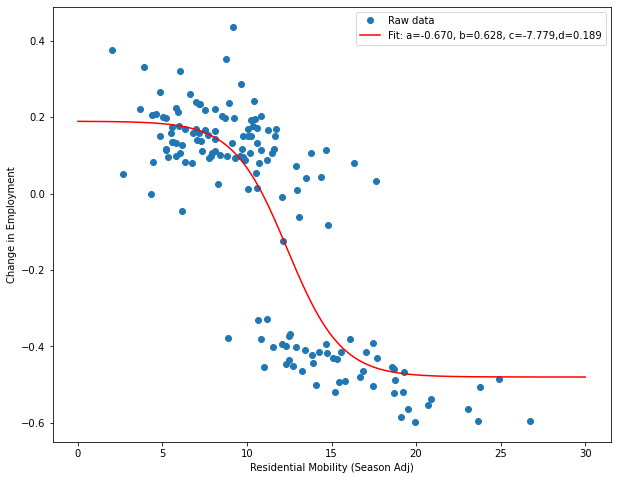

array([-0.6695319 ,  0.62827133, -7.77917507,  0.18943228])

In [71]:
#fitting for data regarding Q2-Leisure and Hospitality

from scipy.optimize import curve_fit

def sigmoid(x,a=0,b=0,c=0,d=0):
    return (a/(1+np.exp(-b*x-c)))+d

popt, pcov = curve_fit(sigmoid, panic['Mob_res_SA'][panic['Sector']=="Leisure and Hospitality"], panic['change_in_emp'][panic['Sector']=="Leisure and Hospitality"])

plt.figure(figsize = (10, 8))

plt.plot(panic['Mob_res_SA'][panic['Sector']=="Leisure and Hospitality"], panic['change_in_emp'][panic['Sector']=="Leisure and Hospitality"], 'o',
    label='Raw data')

plt.plot(np.linspace(0,30,1000), sigmoid(np.linspace(0,30,1000), *popt), 'r',
    label='Fit: a=%5.3f, b=%5.3f, c=%5.3f,d=%5.3f' % tuple(popt))

plt.legend()

plt.xlabel('Residential Mobility (Season Adj)')
plt.ylabel('Change in Employment')

plt.show()
popt

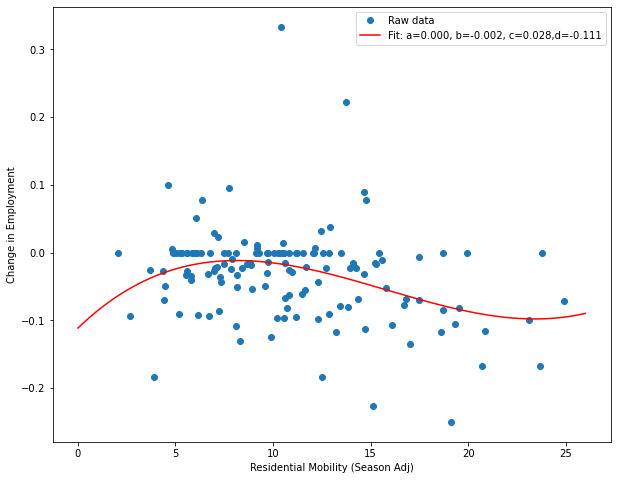

In [72]:
#fitting for data regarding Q2-Mining and Logging
def polym(x,a=0,b=0,c=0,d=0):
    return (a*x**3+b*x**2+c*x+d)

popt, pcov = curve_fit(polym, panic['Mob_res_SA'][panic['Sector']=="Mining and Logging"], 
                       panic['change_in_emp'][panic['Sector']=="Mining and Logging"])

plt.figure(figsize = (10, 8))

plt.plot(panic['Mob_res_SA'][panic['Sector']=="Mining and Logging"], panic['change_in_emp'][panic['Sector']=="Mining and Logging"], 'o',
    label='Raw data')

plt.plot(np.linspace(0,26,1000), polym(np.linspace(0,26,1000), *popt), 'r',
    label='Fit: a=%5.3f, b=%5.3f, c=%5.3f,d=%5.3f' % tuple(popt))

plt.legend()

plt.xlabel('Residential Mobility (Season Adj)')
plt.ylabel('Change in Employment')

plt.show()

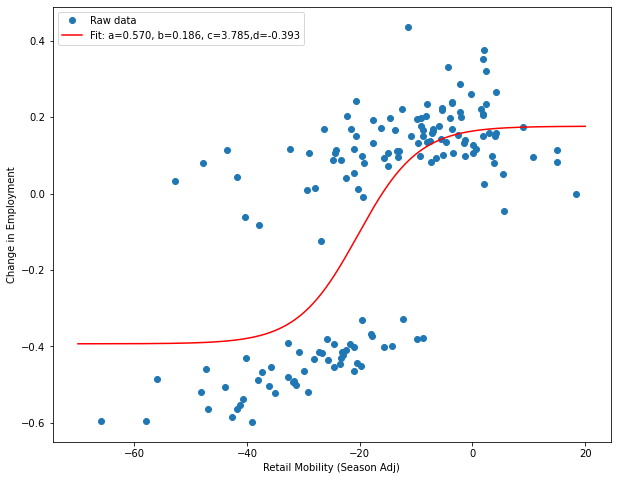

array([ 0.56959055,  0.18615865,  3.78501129, -0.39319076])

In [73]:
#fitting for data regarding Q2-Leisure and Hospitality- Retail

def sigmoid(x,a=0,b=0,c=0,d=0):
    return (a/(1+np.exp(-b*x-c)))+d

popt, pcov = curve_fit(sigmoid, panic['Mob_ret_SA'][panic['Sector']=="Leisure and Hospitality"], 
                       panic['change_in_emp'][panic['Sector']=="Leisure and Hospitality"])

plt.figure(figsize = (10, 8))

plt.plot(panic['Mob_ret_SA'][panic['Sector']=="Leisure and Hospitality"], panic['change_in_emp'][panic['Sector']=="Leisure and Hospitality"], 'o',
    label='Raw data')

plt.plot(np.linspace(-70,20,1000), sigmoid(np.linspace(-70,20,1000), *popt), 'r',
    label='Fit: a=%5.3f, b=%5.3f, c=%5.3f,d=%5.3f' % tuple(popt))

plt.legend()

plt.xlabel('Retail Mobility (Season Adj)')
plt.ylabel('Change in Employment')

plt.show()
popt